moved to zaratan `02a-*`

In [1]:
import csv
import os
import sys
import numpy as np
# import pandas as pd
import scipy as sp 
import pickle
# from os.path import join as pjoin
# from itertools import product
# from tqdm import tqdm
# from copy import deepcopy
# from pathlib import Path
# import subprocess
# from scipy import sparse, stats
# from multiprocessing import Pool
import glob
# from numba import jit
# import arviz as az
# import random

# from itertools import product, combinations
# import multiprocessing as mp
# from functools import partial

# from sklearn.cluster import KMeans
# from sklearn.metrics.pairwise import cosine_similarity
# from munkres import Munkres

# networks
import graph_tool.all as gt

In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

In [3]:
args.type = 'spatial'
args.roi_size = 225
args.maintain_symmetry = True
args.brain_div = 'whl'
args.num_rois = 162

PARC_DESC = (
    f'type-{args.type}'
    f'_size-{args.roi_size}'
    f'_symm-{args.maintain_symmetry}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
)

In [4]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson-corr'
args.THRESHOLDING = f'positive'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'sub'

BASE_path = f'{os.environ["HOME"]}/mouse_dataset/roi_results_v2'
ROI_path = f'{BASE_path}/{PARC_DESC}'
TS_path = f'{ROI_path}/runwise_timeseries'
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLDING}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
DIAG_path = f'{ROI_RESULTS_path}/diagnostics'
os.system(f'mkdir -p {DIAG_path}')

0

In [5]:
args.dc, args.sbm = True, 'o'

args.nested = True if args.sbm in ['h'] else False

args.force_niter = 40
args.num_draws = int((1/2) * args.force_niter)

args.epsilon = 0.4 # threshold KSD for convergence

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['a'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)

In [6]:
gfile = sorted(glob.glob(f'{GRAPH_path}/*', recursive=True))[0]
g = gt.load_graph(gfile)
g

<Graph object, undirected, with 162 vertices and 2608 edges, 1 internal edge property, at 0x7fa288180970>

In [7]:
import graph_tool.all as gt
import numpy as np
import matplotlib.pyplot as plt
import pickle

class ARGS():
    pass

args = ARGS()
args.wait = 24 #24000
args.force_niter = 10
args.niter = 10

# with open(f'graph.pkl', 'rb') as f:
#     g = pickle.load(f)

# state = gt.PPBlockState(g)
state = gt.minimize_blockmodel_dl(g, state=gt.PPBlockState)
# state = gt.minimize_blockmodel_dl(g, state=gt.BlockState)
# state = gt.minimize_blockmodel_dl(g, state=gt.OverlapBlockState)

In [8]:
from multiprocessing import Process, Queue
from functools import wraps

def with_timeout(seconds=5):
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            def worker(queue):
                result = func(*args, **kwargs)
                queue.put(result)

            queue = Queue()
            process = Process(target=worker, args=(queue,))
            process.start()
            process.join(seconds)

            if process.is_alive():
                process.terminate()
                return None
            
            return queue.get()
        return wrapper
    return decorator

@with_timeout(5)
def mcmc_eq(args, g, state):
    bs = [] # partitions
    Bs = np.zeros(g.num_vertices() + 1) # number of blocks
    Bes = [] # number of effective blocks
    dls = [] # description length history
    def collect_partitions(s):
        bs.append(s.b.a.copy())
        # B = s.get_nonempty_B()
        # Bs[B] += 1
        Bes.append(s.get_Be())
        dls.append(s.entropy())

    gt.mcmc_equilibrate(
        state,
        wait=args.wait,
        force_niter=args.force_niter,
        mcmc_args=dict(niter=args.niter),
        callback=collect_partitions,
    )
    return state, bs, Bs, Bes, dls

In [9]:
from tqdm import tqdm
args.total_samples = 10
bs, Bs, Bes, dls = [], [], [], []
with tqdm(total=args.total_samples) as pbar:
    while len(Bes) < args.total_samples:
        res = mcmc_eq(args, g, state)
        if res is not None:
            state, bs_, Bs_, Bes_, dls_ = res
            bs += [bs_] 
            Bs += [Bs_]
            Bes += [Bes_]
            dls += [dls_]
            pbar.update(1)
bs = sum(bs, [])
# Bs = sum(Bs, [])
Bes = sum(Bes, [])
dls = sum(dls, [])

100%|██████████| 10/10 [00:01<00:00,  6.36it/s]


<Axes: ylabel='Density'>

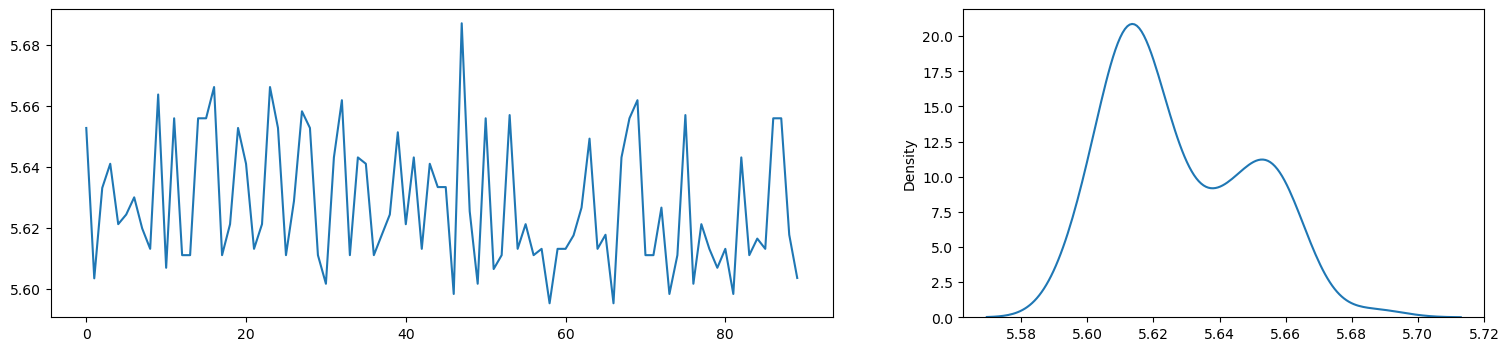

In [10]:
import seaborn as sns
fig, axs = plt.subplots(1, 2, figsize=(18.5, 4), width_ratios=[1.5, 1])
ax = axs[0]
ax.plot(Bes)
ax = axs[1]
sns.kdeplot(Bes, ax=ax)

In [11]:
# with open(f'state.pkl', 'wb') as f:
#     pickle.dump(state, f)